In [84]:
library(tidyverse)
library(lubridate)
library(forcats)
library(nycflights13)
# install.packages("tidytext")
library(tidytext)

# Lecture 15: Dates

## 🤔 Quiz

Every year has 365 days:

<ol style="list-style-type: upper-alpha;">
    <li>True</li>
    <li>False</li>
    <li>I am not physically present in this room.</li>
</ol>

In [ ]:
# year

## 🤔 Quiz

Every day has 24 hours:

<ol style="list-style-type: upper-alpha;">
    <li>True</li>
    <li>False</li>

</ol>

In [64]:
# day

## 🤔 Quiz

Every minute has 60 seconds:

<ol style="list-style-type: upper-alpha;">
    <li>True</li>
    <li>False</li>
</ol>

## Dates
Most of us have a pretty firm grasp on dates. But they can be more complicated than you might think. Consider these three questions from the book:
* Does every year have 365 days?
* Does every day have 24 hours?
* Does every minute have 60 seconds?

The answer to all three is "no".

As before, we'll rely on the `lubridate` package to work with dates:

In [72]:
library(lubridate)

There are three different date classes in R:

* A date, printed in tibble as `<date>`, represents a full day on the calendar.
* A time within a day, printed as `<time>`, represents a specific time within an (unspecified) day.
* A date-time is a date plus a time (tibble: `<dttm>`). A date-time uniquely identifies an instant in time (up to a given precision, usually 1 second.)

We've already seen examples of date-times in the `flights` tibble:

In [73]:
select(flights, time_hour) %>% print

# A tibble: 336,776 x 1
   time_hour          
   <dttm>             
 1 2013-01-01 05:00:00
 2 2013-01-01 05:00:00
 3 2013-01-01 05:00:00
 4 2013-01-01 05:00:00
 5 2013-01-01 06:00:00
 6 2013-01-01 05:00:00
 7 2013-01-01 06:00:00
 8 2013-01-01 06:00:00
 9 2013-01-01 06:00:00
10 2013-01-01 06:00:00
# … with 336,766 more rows


You should tend to favor working with dates over date-times if possible. The latter are more complicated because of the need to handle time zones.



We can get the current date and date-time using the `today()` and `now()` commands:

In [74]:
today()

[1] "2019-10-29"

In [75]:
now()

[1] "2019-10-29 10:07:01 EDT"

### Converting strings to dates and times
Frequently you will be encounter date and/or time data stored as text. You will need to convert these data into the native R date classes in order to use date functions on them. The `mdy/ymd/dmy` functions accomplish this.

In [83]:
ymd("2017 01 31")

[1] "2017-01-31"

In [84]:
mdy("1 31 2017")

dmy("31 1 2017")

[1] "2017-01-31"

[1] "2017-01-31"

### Other languages
You might find yourself needing to parse dates in other languages. This will fail if the dates are in a language which is different from your system's language:

In [65]:
dmy("31 agosto 2017")

Warning message:
“All formats failed to parse. No formats found.”


[1] NA

Fix this by specifying the *locale* option:

In [69]:
dmy("31 août 2017", locale = "fr_FR")

Warning message in Sys.setlocale("LC_TIME", locale):
“OS reports request to set locale to "fr_FR" cannot be honored”


ERROR: Error in Sys.setlocale("LC_TIME", locale): (converted from warning) OS reports request to set locale to "fr_FR" cannot be honored


In [34]:
dmy("31-Jan-2017")

[1] "2017-01-31"

#### Date-time parsers
There are also equivalent functions for parsing date-times:

In [88]:
ymd_hms("2017-01-31 20:11:59")

[1] "2017-01-31 20:11:59 UTC"

In [89]:
mdy_hm("01/31/2017 08:01")

[1] "2017-01-31 08:01:00 UTC"

Sometimes you can get away with calling `as_datetime()`:

In [70]:
as_datetime("2017-01-31 20:11:59")


[1] "2017-01-31 20:11:59 UTC"

But not always:

In [71]:
as_datetime("01/31/2017 08:01")

Warning message:
“All formats failed to parse. No formats found.”


[1] NA

### Making a date-time from components
We saw in the `flights` table that date information can be spread across multiple columns. The `make_date` and `make_datetime` functions can make dates from these:

In [95]:
flights %>% select(year, month, day, dep_time) %>% print

# A tibble: 336,776 x 4
    year month   day dep_time
   <int> <int> <int>    <int>
 1  2013     1     1      517
 2  2013     1     1      533
 3  2013     1     1      542
 4  2013     1     1      544
 5  2013     1     1      554
 6  2013     1     1      554
 7  2013     1     1      555
 8  2013     1     1      557
 9  2013     1     1      557
10  2013     1     1      558
# … with 336,766 more rows


#### Example
The `flights` table has scheduled as well as actual arrival and departure times. Let's create a date-time variable from the actual departure time:

In [98]:
make_datetime_100 = function(year, month, day, time) {
  make_datetime(year, month, day, time %/% 100, time %% 100)
}

flights_dt = flights %>% 
  filter(!is.na(dep_time), !is.na(arr_time)) %>% 
  mutate(
    dep_time = make_datetime_100(year, month, day, dep_time),
    arr_time = make_datetime_100(year, month, day, arr_time),
    sched_dep_time = make_datetime_100(year, month, day, sched_dep_time),
    sched_arr_time = make_datetime_100(year, month, day, sched_arr_time)
  ) %>% 
  select(origin, dest, ends_with("delay"), ends_with("time"))  %>% print

# A tibble: 328,063 x 9
   origin dest  dep_delay arr_delay dep_time            sched_dep_time     
   <chr>  <chr>     <dbl>     <dbl> <dttm>              <dttm>             
 1 EWR    IAH           2        11 2013-01-01 05:17:00 2013-01-01 05:15:00
 2 LGA    IAH           4        20 2013-01-01 05:33:00 2013-01-01 05:29:00
 3 JFK    MIA           2        33 2013-01-01 05:42:00 2013-01-01 05:40:00
 4 JFK    BQN          -1       -18 2013-01-01 05:44:00 2013-01-01 05:45:00
 5 LGA    ATL          -6       -25 2013-01-01 05:54:00 2013-01-01 06:00:00
 6 EWR    ORD          -4        12 2013-01-01 05:54:00 2013-01-01 05:58:00
 7 EWR    FLL          -5        19 2013-01-01 05:55:00 2013-01-01 06:00:00
 8 LGA    IAD          -3       -14 2013-01-01 05:57:00 2013-01-01 06:00:00
 9 JFK    MCO          -3        -8 2013-01-01 05:57:00 2013-01-01 06:00:00
10 LGA    ORD          -2         8 2013-01-01 05:58:00 2013-01-01 06:00:00
# … with 328,053 more rows, and 3 more variables: arr_time <dttm

Now we can use built in R command to query and plot these data based on actual departure time:

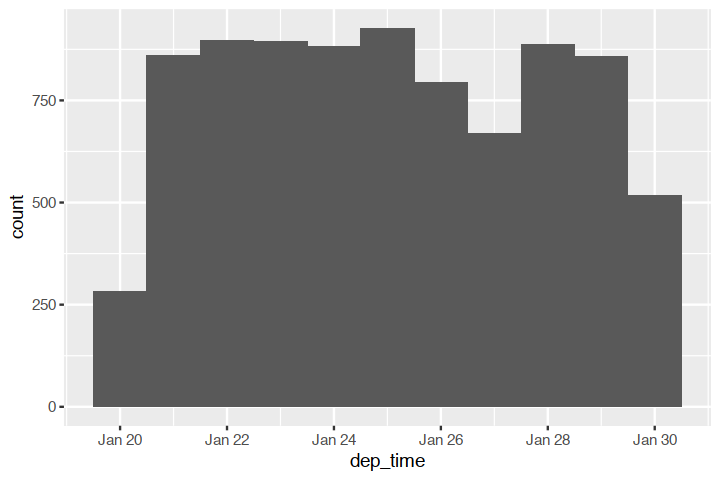

In [112]:
flights_dt %>% 
  filter(dep_time < ymd(20130130), dep_time >= ymd(20130120)) %>% 
  ggplot(aes(x=dep_time)) + 
  geom_histogram(binwidth = 24 * 60 * 60)

Notice that this command and resulting graph looks much nicer than if we did not use the date classes:
* The filter on `dep_time` looks more natural than `filter(day<2, month==1, year==2013)`.
* We can easily express the bin-width of 600 seconds in `geom_freqpoly(binwidth = 600)`. When you use date-times in a numeric context (like in a histogram), 1 means 1 second; for dates, 1 means 1 day.
* The plot x axis has nice readable labels.

### The epoch
UNIX systems sometimes represent time as "the number of seconds which have elapsed since 1-1-1970." This date is known as "the epoch". So you may occasionally come across date-times that look like:

In [115]:
now() %>% as.integer() 

[1] 1572358737

To convert these to date format you can use `as_datetime`:

In [72]:
as_datetime(3600 * 24)  # 24 hours after the epoch

[1] "1970-01-02 UTC"

## 🤔 Quiz

Julian was born on September 22, 2019 at 1:05PM EDT. How many seconds old is Julian?

<ol style="list-style-type: upper-alpha;">
    <li>About $10^7$</li>
    <li>About $10^8$</li>
    <li>About $10^9$</li>
    <li>About $10^{10}$</li>
</ol>

In [78]:
# second old

### Date-time components
The functions `year()`, `month()`, `mday()` (day of the month), `yday()` (day of the year), `wday()` (day of the week), `hour()`, `minute()`, and `second()` can extract components from dates and times:

In [149]:
mdy_hms(c("March 12, 2018 12:00:00")) 

[1] "2018-03-12 12:00:00 UTC"

By extracting the minute component of scheduled departure time, we uncover a surprising pattern:

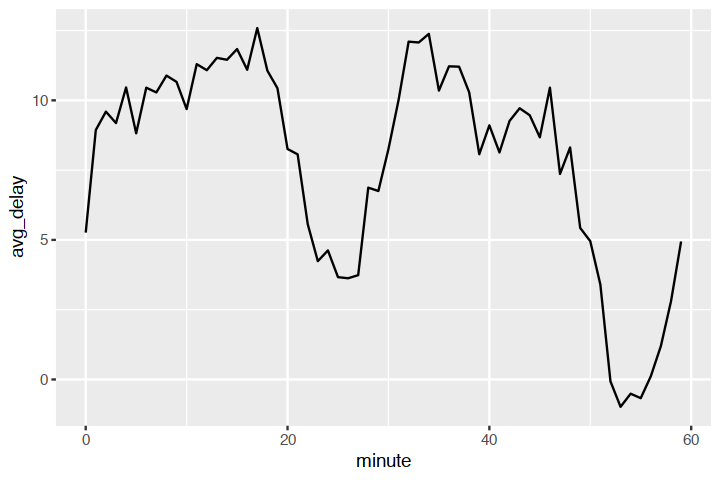

In [49]:
flights_dt %>% 
  mutate(minute = minute(dep_time)) %>% 
  group_by(minute) %>% 
  summarise(
    avg_delay = mean(arr_delay, na.rm = TRUE),
    n = n()) %>% 
  ggplot(aes(minute, avg_delay)) +
    geom_line()

On the other hand, when grouped by scheduled departure time the delays seem to be random:

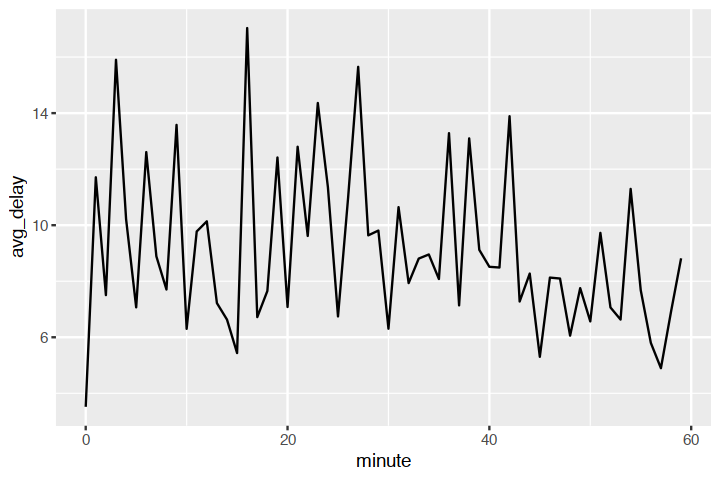

In [50]:
sched_dep <- flights_dt %>% 
  mutate(minute = minute(sched_dep_time)) %>% 
  group_by(minute) %>% 
  summarise(
    avg_delay = mean(arr_delay, na.rm = TRUE),
    n = n())

ggplot(sched_dep, aes(minute, avg_delay)) +
  geom_line()

As explained by the book, there is a bias in scheduled departure times towards nice round numbers:

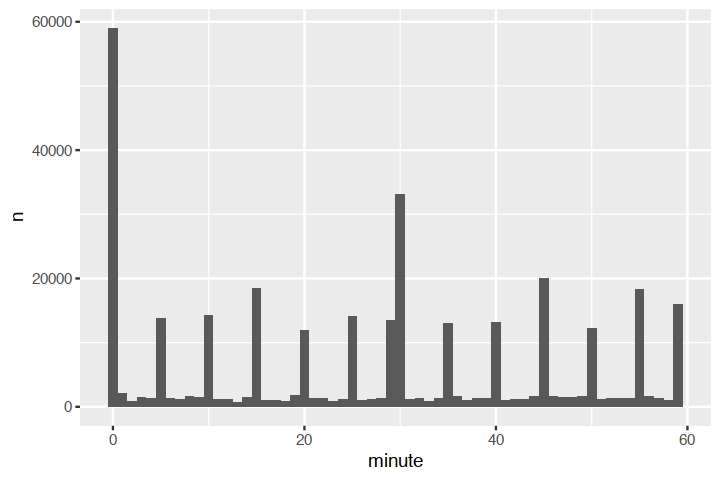

In [51]:
ggplot(sched_dep, aes(minute, n)) + geom_col()

#### As accessors
The component functions also work as accessors, meaning they can be used on the left-hand side of an assignment:

In [52]:
(d = today())
mday(d) = 24
d

[1] "2019-10-29"

[1] "2019-10-24"

To return a new (date)time rather than modifying in place, you can use the `update` command:

In [53]:
update(today(), year=2020)

[1] "2020-10-29"

### Time spans
Time spans are the difference between two time points. These are represented in R by the `difftime` class:

In [54]:
(d = today() - update(today(), year=2010))
class(d)

Time difference of 3287 days

[1] "difftime"

Because it is usually simpler to reason about time differences in terms of a single number, `lubridate` also provides a `duration` class which is stored in terms of seconds:

In [55]:
as.duration(1234)

[1] "1234s (~20.57 minutes)"

In [56]:
dseconds(10)

[1] "10s"

In [57]:
dweeks(3)

[1] "1814400s (~3 weeks)"

Arithmetic with durations works as you would expect:

In [58]:
2 * dyears(1)

[1] "63072000s (~2 years)"

In [59]:
dyears(1) + dweeks(12) + dhours(15)

[1] "38847600s (~1.23 years)"

You have to be careful when adding durations and dates. What is 1 day after this Saturday at 1pm?

In [158]:
next_saturday = mdy_hm("Nov. 2, 2019 13:00PM", tz="America/Detroit")
next_saturday + ddays(1)

[1] "2019-11-03 12:00:00 EST"

To prevent this sort of thing from happening, `lubridate` also offers objects called "periods":

In [61]:
days(1)
class(days(1))

[1] "1d 0H 0M 0S"

[1] "Period"
attr(,"package")
[1] "lubridate"

Similarly, periouds have the expected behaviour if you add one year to a leap year:

In [159]:
ymd("2016-01-01") + dyears(1)

[1] "2016-12-31"

In [66]:
ymd("2016-01-01") + years(1)

[1] "2017-01-01"

### Exercise
Jack is 20,000 days old today. What is Jack's birthday?

In [67]:
today() - ddays(20000)

[1] "1965-01-25"

#### Example
Earlier in the semester we saw how some flights seem to have arrived before they departed:

In [68]:
filter(flights, arr_time < dep_time) %>% head %>% print

# A tibble: 6 x 19
   year month   day dep_time sched_dep_time dep_delay arr_time sched_arr_time
  <int> <int> <int>    <int>          <int>     <dbl>    <int>          <int>
1  2013     1     1     1929           1920         9        3              7
2  2013     1     1     1939           1840        59       29           2151
3  2013     1     1     2058           2100        -2        8           2359
4  2013     1     1     2102           2108        -6      146            158
5  2013     1     1     2108           2057        11       25             39
6  2013     1     1     2120           2130       -10       16             18
# … with 11 more variables: arr_delay <dbl>, carrier <chr>, flight <int>,
#   tailnum <chr>, origin <chr>, dest <chr>, air_time <dbl>, distance <dbl>,
#   hour <dbl>, minute <dbl>, time_hour <dttm>


This is because these are overnight flights. To fix this, we can now simply add one day to `arr_time`:

In [69]:
flights_dt = flights_dt %>% 
  mutate(
    overnight = arr_time < dep_time,
    arr_time = arr_time + days(overnight * 1),
    sched_arr_time = sched_arr_time + days(overnight * 1)
  ) %>% print

# A tibble: 328,063 x 10
   origin dest  dep_delay arr_delay dep_time            sched_dep_time     
   <chr>  <chr>     <dbl>     <dbl> <dttm>              <dttm>             
 1 EWR    IAH           2        11 2013-01-01 05:17:00 2013-01-01 05:15:00
 2 LGA    IAH           4        20 2013-01-01 05:33:00 2013-01-01 05:29:00
 3 JFK    MIA           2        33 2013-01-01 05:42:00 2013-01-01 05:40:00
 4 JFK    BQN          -1       -18 2013-01-01 05:44:00 2013-01-01 05:45:00
 5 LGA    ATL          -6       -25 2013-01-01 05:54:00 2013-01-01 06:00:00
 6 EWR    ORD          -4        12 2013-01-01 05:54:00 2013-01-01 05:58:00
 7 EWR    FLL          -5        19 2013-01-01 05:55:00 2013-01-01 06:00:00
 8 LGA    IAD          -3       -14 2013-01-01 05:57:00 2013-01-01 06:00:00
 9 JFK    MCO          -3        -8 2013-01-01 05:57:00 2013-01-01 06:00:00
10 LGA    ORD          -2         8 2013-01-01 05:58:00 2013-01-01 06:00:00
# … with 328,053 more rows, and 4 more variables: arr_time <dtt

### Time zones
When we create a date-time, the default time zone is "UTC":

In [70]:
ymd_hm("2000-01-30 00:00")

[1] "2000-01-30 UTC"

This is a standard time zone which is, for historical reasons, equal to time in Greenwich, England.

If your times are coming from a different time zone you must specify using the `tz=` option:

In [71]:
ymd_hms("2017-6-30 20:11:59", tz="America/Ann_Arbor")
ymd_hms("2017-6-30 20:11:59", tz="America/Los_Angeles")

ERROR: Error in C_force_tz(time, tz = tzone, roll): CCTZ: Unrecognized output timezone: "America/Ann_Arbor"


You can find your local time zone using:

In [ ]:
Sys.timezone()

The command `OlsonNames()` will list all the possible time zones:

In [ ]:
length(OlsonNames())
sample(OlsonNames(), 10)

## Trump Twitter data
Let's use what we learned in the past two classes to analyze some real data. 

In [81]:
trump_tweets <- read_csv("https://github.com/MarkHershey/CompleteTrumpTweetsArchive/blob/master/data/realDonaldTrump_in_office.csv?raw=true")

Warning message:
“One or more parsing issues, call `problems()` on your data frame for details, e.g.:
  dat <- vroom(...)
  problems(dat)”
Rows: 23073 Columns: 4
── Column specification ─────────────────────────────────────────────────────────────────────────────────────────────
Delimiter: ","
chr  (3): ID, Tweet URL, Tweet Text
dttm (1): Time

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


`trump_tweets` is a dataset of all 23,073 Tweets that Donald Trump sent between taking office and getting kicked off Twitter in Jan 2021.

In [85]:
tail(trump_tweets)

ID,Time,Tweet URL,Tweet Text
<chr>,<dttm>,<chr>,<chr>
@realDonaldTrump,2021-01-07 03:38:00,https://twitter.com/realDonaldTrump/status/1346904110969315332,Please support our Capitol Police and Law Enforcement. They are truly on the side of our Country. Stay peaceful!
@realDonaldTrump,2021-01-07 04:13:00,https://twitter.com/realDonaldTrump/status/1346912780700577792,"I am asking for everyone at the U.S. Capitol to remain peaceful. No violence! Remember, WE are the Party of Law &amp; Order – respect the Law and our great men and women in Blue. Thank you!"
@realDonaldTrump,2021-01-07 05:17:00,https://twitter.com/realDonaldTrump/status/1346928882595885058,https://t.co/Pm2PKV0Fp3
@realDonaldTrump,2021-01-08 08:10:00,https://twitter.com/realDonaldTrump/status/1347334804052844550,https://t.co/csX07ZVWGe
@realDonaldTrump,2021-01-08 22:46:00,https://twitter.com/realDonaldTrump/status/1347555316863553542,"The 75,000,000 great American Patriots who voted for me, AMERICA FIRST, and MAKE AMERICA GREAT AGAIN, will have a GIANT VOICE long into the future. They will not be disrespected or treated unfairly in any way, shape or form!!!"
@realDonaldTrump,2021-01-08 23:44:00,https://twitter.com/realDonaldTrump/status/1347569870578266115,To all of those who have asked


### Task #2
Plot the number of Tweets that Donald Trump has made for each quarter of the year from 2010 to present.
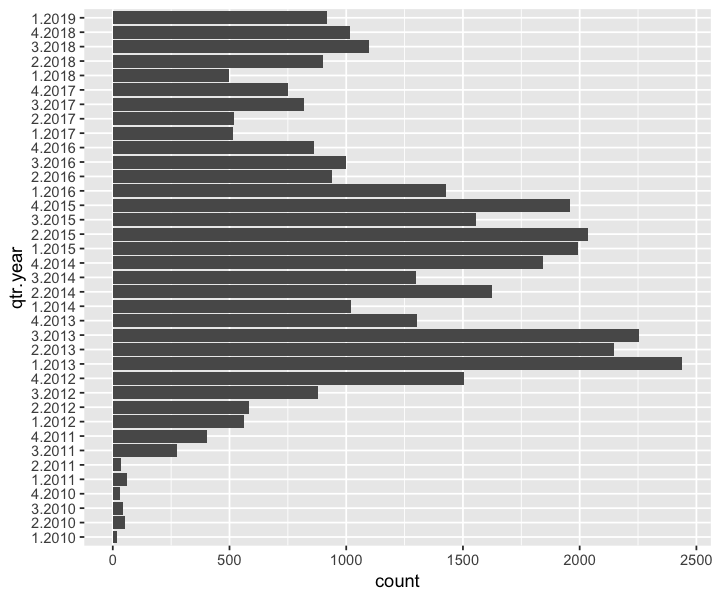

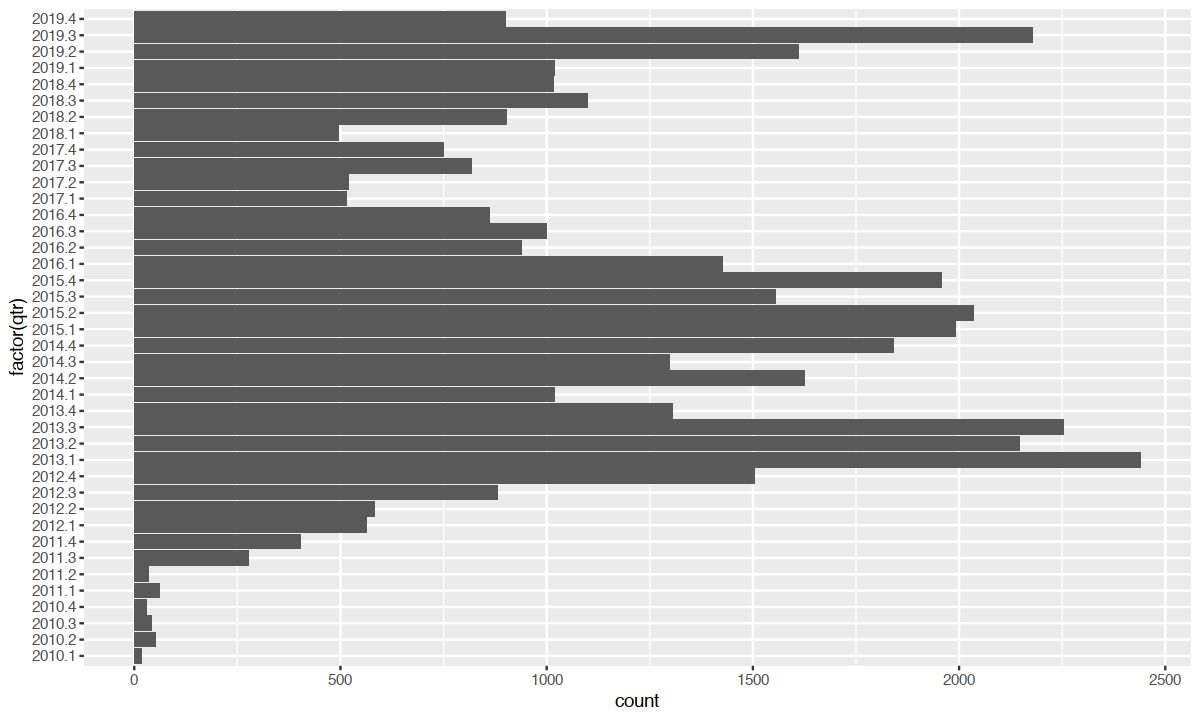

In [65]:
trump_tweets2 %>% mutate(year = year(dt), 
                         qtr = quarter(dt, with_year = T)) %>% 
    ggplot + geom_bar(aes(x=factor(qtr))) + coord_flip()

### Task #3
Recall that `words` contains common English words. After filtering out these words, and all words that were shorter than six characters, the most common words that the President used in 2018 were:

```
# A tibble: 11 x 2
   words               n
   <chr>           <int>
 1 american          161
 2 border            269
 3 collusion         133
 4 democrats         291
 5 military          183
 6 president         356
 7 realdonaldtrump   182
 8 russia            133
 9 security          151
10 states            150
11 united            150

```

What about for 2012?

In [85]:
filter(trump_tweets2, year(dt) == 2019) %>% 
    unnest_tokens(output = word, input = text) %>%
    select(created_at, word) %>% 
    count(word) %>% 
    filter(str_length(word) >= 6) %>% top_n(15)




Selecting by n


   word            n  
1  america         236
2  american        232
3  because         182
4  border          384
5  country         390
6  democrats       512
7  mueller         191
8  nothing         196
9  people          512
10 president       746
11 realdonaldtrump 486
12 should          274
13 states          239
14 united          252
15 whitehouse      184

### Task #4
What were the president's favorite #hashtags in 2018? 2012?

In [113]:
library(tidytext)

filter(trump_tweets2, str_detect(text, "#")) %>% 
    unnest_tokens(input=text, output=word, token="tweets") %>% 
    filter(str_detect(word, "^#")) %>% 
    count(year(dt), word) %>% top_n(20) %>% arrange(desc(n))

Selecting by n


   year(dt) word                   n  
1  2015     #trump2016             415
2  2016     #trump2016             347
3  2015     #makeamericagreatagain 279
4  2016     #makeamericagreatagain 275
5  2013     #celebapprentice       140
6  2015     #celebapprentice       139
7  2016     #maga                  108
8  2014     #trump2016             107
9  2015     #celebrityapprentice   102
10 2016     #americafirst           86
11 2016     #draintheswamp          78
12 2016     #votetrump              69
13 2018     #maga                   67
14 2011     #timetogettough         62
15 2016     #imwithyou              62
16 2016     #bigleaguetruth         58
17 2015     #trump                  53
18 2019     #maga                   46
19 2016     #debate                 45
20 2011     #trumpvlog              43

### Task #5
At what hour of the day (or night) is the Donald Trump most likely to tweet, and how has this changed over time?

In [21]:
# Solution

### Task #6
"Sentiment analysis" refers to the act of assigning a label such as "positive" or "negative" to a piece of text. We will perform a simple type of sentiment analysis by assigning a numerical score to certain words in each tweet, using the `sentiments` table:

In [115]:
library(tidytext)
sentiments %>% print

# A tibble: 27,314 x 4
   word        sentiment lexicon score
   <chr>       <chr>     <chr>   <int>
 1 abacus      trust     nrc        NA
 2 abandon     fear      nrc        NA
 3 abandon     negative  nrc        NA
 4 abandon     sadness   nrc        NA
 5 abandoned   anger     nrc        NA
 6 abandoned   fear      nrc        NA
 7 abandoned   negative  nrc        NA
 8 abandoned   sadness   nrc        NA
 9 abandonment anger     nrc        NA
10 abandonment fear      nrc        NA
# … with 27,304 more rows


An example of how this works:

In [126]:
trump_sentiments <- trump_tweets2 %>%
    mutate(month = month(dt), year = year(dt)) %>%
    unnest_tokens(input=text, output=word, token="tweets") %>% 
    inner_join(sentiments) %>% drop_na(score)

Joining, by = "word"


Average the sentiment by month for the full data set, and make a plot of the monthly average from 2014 to 2018. 

President Trump declared his candidacy in June of 2015. Notice anything?

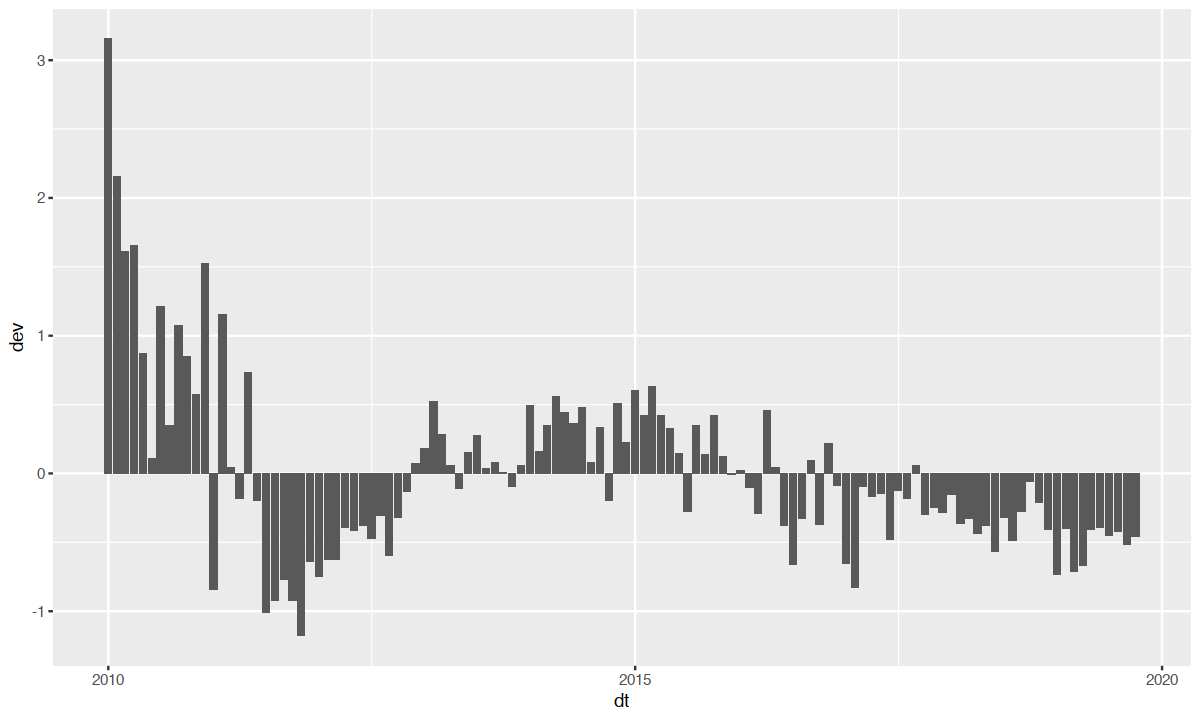

In [130]:
trump_sentiments %>% group_by(year, month) %>% 
    summarize(m = mean(score), n = n()) %>% ungroup %>%
    mutate(dev = m - mean(m), dt = make_date(year, month, 1)) %>% 
    ggplot + geom_col(aes(x = dt, y = dev))

In [ ]:
## Trump Twitter data
We will now use what we have learned in the past two classes to analyze some real data. 

load("tt.RData")  # see tt/load_tweets.ipynb for code that produces this data.

trump_tweets %>% slice(1)

`trump_tweets` is a dataset of all ~~37,169~~ 41,958 Tweets that Donald Trump has sent since 2010.

# print(trump_tweets)
dttm <- "Thu Dec 30 21:42:01 +0000 2010"
splitted <- str_split(dttm, " ")[[1]] %>% print
make_date()
ymd(str_c(splitted[6], splitted[2], splitted[3], sep=" "))

### Task #1
Each tweet has a timestamp in the `created_at` column. We want to convert this column to a proper date-time object so that we can analyze the time component of these tweets.

trump_tweets2 <- trump_tweets %>% mutate(
    dt=str_replace(created_at,
    "\\w+ (\\w+ \\d+) ([\\d:]+) \\+0000 (\\d{4})",
    "\\1 \\3 \\2") %>% mdy_hms) %>% print

### Task #2
Plot the number of Tweets that Donald Trump has made for each quarter of the year from 2010 to present.
![image.png](attachment:image.png)

trump_tweets2 %>% mutate(year = year(dt), 
                         qtr = quarter(dt, with_year = T)) %>% 
    ggplot + geom_bar(aes(x=factor(qtr))) + coord_flip()

### Task #3
Recall that `words` contains common English words. After filtering out these words, and all words that were shorter than six characters, the most common words that the President used in 2018 were:

```
# A tibble: 11 x 2
   words               n
   <chr>           <int>
 1 american          161
 2 border            269
 3 collusion         133
 4 democrats         291
 5 military          183
 6 president         356
 7 realdonaldtrump   182
 8 russia            133
 9 security          151
10 states            150
11 united            150

```

What about for 2012?

filter(trump_tweets2, year(dt) == 2019) %>% 
    unnest_tokens(output = word, input = text) %>%
    select(created_at, word) %>% 
    count(word) %>% 
    filter(str_length(word) >= 6) %>% top_n(15)




### Task #4
What were the president's favorite #hashtags in 2018? 2012?

library(tidytext)

filter(trump_tweets2, str_detect(text, "#")) %>% 
    unnest_tokens(input=text, output=word, token="tweets") %>% 
    filter(str_detect(word, "^#")) %>% 
    count(year(dt), word) %>% top_n(20) %>% arrange(desc(n))

### Task #5
At what hour of the day (or night) is the Donald Trump most likely to tweet, and how has this changed over time?

# Solution

### Task #6
"Sentiment analysis" refers to the act of assigning a label such as "positive" or "negative" to a piece of text. We will perform a simple type of sentiment analysis by assigning a numerical score to certain words in each tweet, using the `sentiments` table:

library(tidytext)
sentiments %>% print

An example of how this works:

trump_sentiments <- trump_tweets2 %>%
    mutate(month = month(dt), year = year(dt)) %>%
    unnest_tokens(input=text, output=word, token="tweets") %>% 
    inner_join(sentiments) %>% drop_na(score)

Average the sentiment by month for the full data set, and make a plot of the monthly average from 2014 to 2018. 

President Trump declared his candidacy in June of 2015. Notice anything?

trump_sentiments %>% group_by(year, month) %>% 
    summarize(m = mean(score), n = n()) %>% ungroup %>%
    mutate(dev = m - mean(m), dt = make_date(year, month, 1)) %>% 
    ggplot + geom_col(aes(x = dt, y = dev))